# Enrich text with Field of Research (FoR) codes

In this tutorial, we show how to use the [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/) *classify* function to retrieve suggested Field of Research (FoR) codes for a set of documents. 

FoR classification is a component of the Australian and New Zealand Standard Research Classification system. It allows all R&D activity to be categorized using a single system. The system is hierarchical, with major fields subdivided into minor fields. 

For more information on FoR classification, please see [this article](https://dimensions.freshdesk.com/support/solutions/articles/23000018826-what-is-the-background-behind-the-fields-of-research-for-classification-system-). For a complete list of all FoR categories in Dimensions, please visit [this link](https://app.dimensions.ai/browse/categories/publication/for).

The [Dimensions API classifier](https://docs.dimensions.ai/dsl/functions.html#function-classify) suggests category classifications based on input title and abstract text. Category classifications allow analysts to gain insight into the area(s) of focus of a set of documents. For example, given a set of documents, how many of the documents relate to 'Artificial Intelligence and Image Processing' (FoR code 0801)? How does this compare to the number of documents related to 'Statistics' (FoR code 0104)?

## A sample set of publications

Our starting point is a [sample set of 100 titles/abstracts](http://api-sample-data.dimensions.ai/data/arxiv_june7.csv) belonging to publications that were submitted to arxiv.org on June 7th 2021. At the time of writing, these publications have not yet been indexed by Dimensions, and thus have not yet been assigned categories. 

Below, we will show below how to enrich this dataset with FoR codes.

In [1]:
import datetime
print("==\nCHANGELOG\nThis notebook was last run on %s\n==" % datetime.date.today().strftime('%b %d, %Y'))

==
CHANGELOG
This notebook was last run on Aug 14, 2023
==


## Prerequisites

This notebook assumes you have installed the [Dimcli](https://pypi.org/project/dimcli/) library and are familiar with the ['Getting Started' tutorial](https://api-lab.dimensions.ai/cookbooks/1-getting-started/1-Using-the-Dimcli-library-to-query-the-API.html).

In [2]:
!pip install dimcli tqdm -U --quiet 

import dimcli
from dimcli.utils import *

import sys, json, time, os
import pandas as pd
import plotly.express as px  # plotly>=4.8.1
from tqdm.notebook import tqdm as pbar
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)

print("==\nLogging in..")
# https://digital-science.github.io/dimcli/getting-started.html#authentication
ENDPOINT = "https://app.dimensions.ai"
if 'google.colab' in sys.modules:
  import getpass
  KEY = getpass.getpass(prompt='API Key: ')  
  dimcli.login(key=KEY, endpoint=ENDPOINT)
else:
  KEY = ""
  dimcli.login(key=KEY, endpoint=ENDPOINT)
dsl = dimcli.Dsl()

Searching config file credentials for 'https://app.dimensions.ai' endpoint..


==
Logging in..
Dimcli - Dimensions API Client (v1.1)
Connected to: <https://app.dimensions.ai/api/dsl> - DSL v2.7
Method: dsl.ini file


## 1. Loading the sample text

First, we are going to load the sample dataset '[arxiv_june7.csv](http://api-sample-data.dimensions.ai/data/arxiv_june7.csv)'.

In [3]:
df = pd.read_csv('http://api-sample-data.dimensions.ai/data/arxiv_june7.csv')

Let's preview the contents of the file:

In [4]:
df.head()

,title,abstract
0,SIMONe View Invariant Temporally Abstracted ...,To help agents reason about scenes in terms ...
1,How planets grow by pebble accretion IV Envel...,The amount of nebular gas that a planet can ...
2,GAN Cocktail mixing GANs without dataset access,Today s generative models are capable of syn...
3,it CosmoPower emulating cosmological p...,We present it CosmoPower a suite of neu...
4,A Matrix Trickle Down Theorem on Simplicial Co...,We show that the natural Glauber dynamics mi...


As we see above, each document is represented by title text and abstract text. We will use the Dimensions API's *classify* function to retrieve suggested FoR codes for this text. 

## 2. FoR Classification

The [*classify*](https://docs.dimensions.ai/dsl/functions.html#function-classify) function has three inputs: title, abstract, and system. 

* **title**: the document's title text
* **abstract**: the document's abstract text
* **system**: the desired classification system for output

In our case, we're going to use the FoR classification system. For details on other available classification schemes, please see [this article](https://support-funder.dimensions.ai/support/solutions/articles/13000037672-which-research-categories-and-classification-schemes-are-available-in-dimensions-). 

To classify each document, we iterate through the dataframe one row at a time and input the title and abstract text for each document. A list of suggested FoR codes is saved into a column called 'FoR_Categories'.

We pause for a second after each iteration, which prevents us from hitting the max queries quota (~30 per minute).

In [5]:
df['FoR_Categories'] = ''

In [6]:
for index, row in pbar(df.iterrows(), total=df.shape[0]):
    search_string = f"""
                    classify(title="{row.title}", abstract="{row.abstract}", system="FOR")
            """
    a = dsl.query(search_string, verbose=False)
    list_of_categories = []
    for x in a.json['FOR_2020']:
        list_of_categories.append(x['name'])
    df['FoR_Categories'][index] = list_of_categories
    time.sleep(1)

  0%|          | 0/100 [00:00<?, ?it/s]

Now that we have classified our documents, let's take a look at the updated dataframe:

In [7]:
df.head(20)

,title,abstract,FoR_Categories
0,SIMONe View Invariant Temporally Abstracted ...,To help agents reason about scenes in terms ...,[4603 Computer Vision and Multimedia Computati...
1,How planets grow by pebble accretion IV Envel...,The amount of nebular gas that a planet can ...,[5109 Space Sciences]
2,GAN Cocktail mixing GANs without dataset access,Today s generative models are capable of syn...,[4611 Machine Learning]
3,it CosmoPower emulating cosmological p...,We present it CosmoPower a suite of neu...,[5107 Particle and High Energy Physics]
4,A Matrix Trickle Down Theorem on Simplicial Co...,We show that the natural Glauber dynamics mi...,"[4904 Pure Mathematics, 4901 Applied Mathematics]"
5,Mean Shifted Contrastive Loss for Anomaly Dete...,Deep anomaly detection methods learn represe...,[4611 Machine Learning]
6,Equivariant Graph Neural Networks for D Macro...,Representing and reasoning about D structur...,[4611 Machine Learning]
7,Non Abelian Hybrid Fracton Orders,We introduce lattice gauge theories which de...,"[4902 Mathematical Physics, 4904 Pure Mathemat..."
8,A Helix Down the Throat Internal Tidal Effects,Tidal effects in capped geometries computed ...,"[4902 Mathematical Physics, 5107 Particle and ..."
9,Balancing Garbage Collection vs I O Amplificat...,Key value KV separation is a technique tha...,[4606 Distributed Computing and Systems Software]


Above, we see that some document texts did not receive any suggested FoR codes, while others received multiple codes. The classifier is programmed assign each document 0-4 FoR codes. It may fail to classify or produce unexpected results when working with longer texts. 

## 3. Number of FoR categories per document

Below, we plot the frequency of each count of categories using plotly:

In [8]:
df['Counts'] = ''
for index, row in df.iterrows():
    df['Counts'][index] = len(df['FoR_Categories'][index])

grouped = df.groupby(by = "Counts", as_index = False).agg(Occurences = ("Counts", "size"))

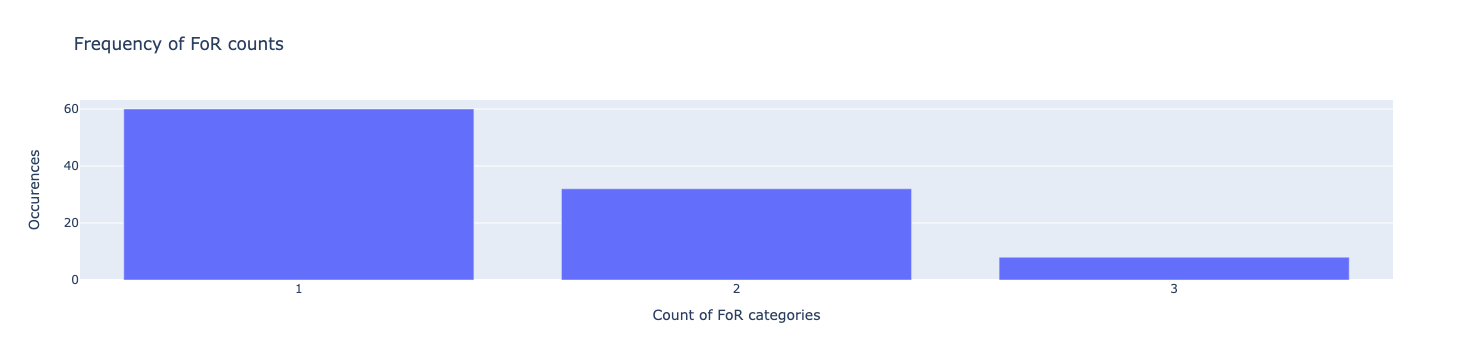

In [9]:
fig = px.bar(
    x = grouped["Counts"],
    y = grouped["Occurences"], 
    title = "Frequency of FoR counts",
    labels = {"x": "Count of FoR categories", "y": "Occurences"}
)

fig.update_layout(xaxis = dict(tickvals = [1, 2, 3])) #set sensible tick marks
fig.show()

Here, we see that of the documents that were successfully classified, the majority received only one FoR assignment. 

## 4. Top FoR categories by document count

Below, we plot the top 10 FoR categories by document count.

In [10]:
all_codes = pd.Series([category for item in df.FoR_Categories for category in item])
code_counts = all_codes.value_counts()

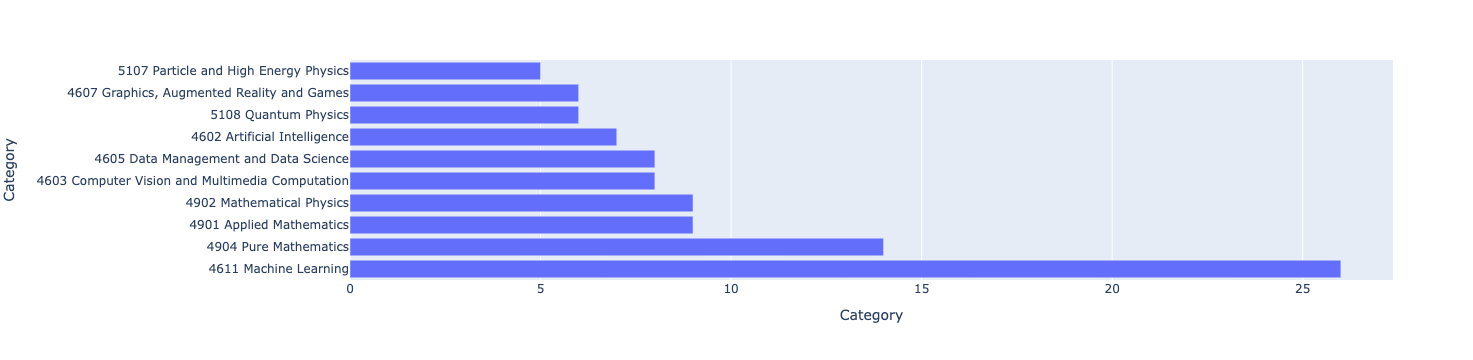

In [11]:
fig = px.bar(code_counts[:10], orientation = "h")
fig.update_layout(xaxis_title = "Category", yaxis_title = "Category", showlegend = False)

fig.show()

'Machine Learning' is the most common FoR category,  followed by 'Pure Mathematics'.

---
## Conclusions

In this notebook we have shown how to use the [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/) *classify* function to retrieve suggested Field of Research (FoR) codes for a set of documents. 

For more background, see the [classify function documentation](https://docs.dimensions.ai/dsl/functions.html#function-classify), as well as the other functions available via the Dimensions API. 
